
## HySWAN Metamodel: Waves dataset propagation to a point.

This is a very simplified example of HySWAN toolbox. 

A waves series dataset will be propagated to a coastal point using the statistical-numerical metamodel, reducing number of SWAN cases to execute, and therefore computational resources required.

SWAN scenario is a demo case based on Roi-namur (Kwajalein atoll).

<strong>Workflow</strong>:


- Generate a waves subset using Maximum Dissimilarity Algorithm (MDA) classification from waves series dataset.
- Numerical solve waves propagations, using MDA waves subset as SWAN boundary conditions. Store propagated waves at a point.
- Feed SWAN input / output to a Radial Basis Functions model.
- Use RBF interpolator to statistically reconstruct propagation for the entire waves series dataset.


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_STAT
from hywaves.swan.plots.stationary import scatter_maps

# statistics
from hywaves.statistical.mda import MaxDiss_Simplified_NoThreshold
from hywaves.statistical.rbf import RBF_Reconstruction, RBF_Validation

# plotting
from hywaves.statistical.plots.mda import Plot_MDA_Data



## Database

In [2]:
# --------------------------------------
# data
p_data = op.abspath(op.join(os.path.abspath(''), '..', '..', 'data'))
p_demo = op.join(p_data, 'demo', 'nb_demo_roi')

# swan main and nest1 mesh
p_swan_ext = op.join(p_demo, 'Roinamur_ext_bottom.dat')
p_swan_int = op.join(p_demo, 'Roinamur_int_bottom.dat')

# waves data
p_waves = op.join(p_demo, 'waves_historical.nc')

# roi shore (for plots)
p_shore = op.join(p_demo, 'shore.npy')
np_shore = np.load(p_shore)


In [3]:
# load waves dataset
dataset = xr.open_dataset(p_waves)  # > 300000 waves cases

# prepare waves data for SWAN STATIONARY 
dataset = dataset[['Hs', 'Tp', 'Dir']].to_dataframe()[1:]
dataset.rename(columns={"Hs":"hs", "Tp":"tp", "Dir": "dir"}, inplace=True)

print(dataset)


                                     hs        tp        dir
time                                                        
1979-01-01 00:59:59.999986560  0.526302  2.780521  68.265551
1979-01-01 02:00:00.000013440  0.836201  3.526751  70.859670
1979-01-01 03:00:00.000000000  1.063496  4.161158  73.547036
1979-01-01 03:59:59.999986560  1.221201  4.587750  74.101988
1979-01-01 05:00:00.000013440  1.346811  4.950551  73.434447
...                                 ...       ...        ...
2020-06-30 20:00:00.000013312  0.978911  8.029230  63.577090
2020-06-30 21:00:00.000000000  0.976827  8.030317  62.778190
2020-06-30 21:59:59.999986688  0.973691  8.029948  62.099051
2020-06-30 23:00:00.000013312  0.970341  8.023516  61.521886
2020-07-01 00:00:00.000000000  0.967821  8.014340  61.103933

[363768 rows x 3 columns]



## Maximum Dissimilarity Algorithm (MDA) classification

In [4]:
# --------------------------------------
# Set MDA parameters

# variables to use
vns = ['hs', 'tp', 'dir']

# subset size, scalar and directional indexes
n_subset = 125            # subset size (very small for this conceptual example)
ix_scalar = [0, 1]        # hs, tp
ix_directional = [2]      # dir



MaxDiss waves parameters: 363768 --> 125

   MDA centroids: 125/125



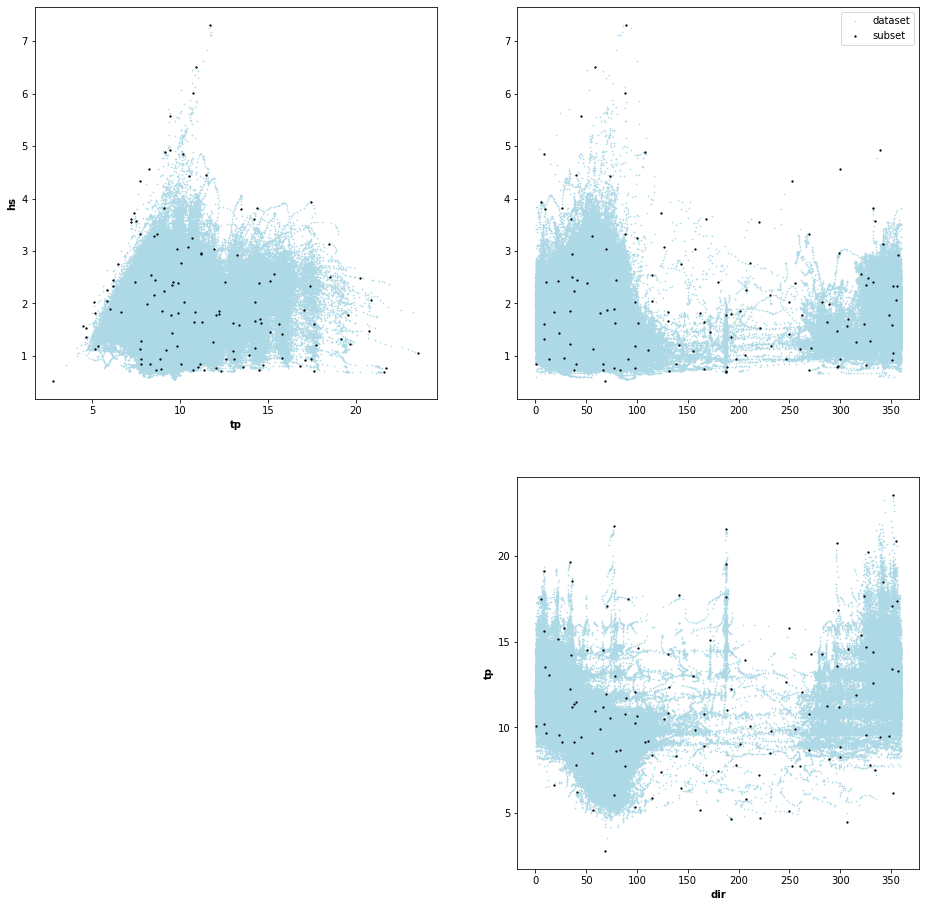

In [5]:
# MDA algorithm
sel = MaxDiss_Simplified_NoThreshold(dataset[vns].values[:], n_subset, ix_scalar, ix_directional)
subset = pd.DataFrame(data=sel, columns=vns)

# plot classification
Plot_MDA_Data(dataset, subset);


In [6]:
# fill/fix subset variables for SWAN execution

subset['spr'] = 40  # set directional spread
subset.rename(columns={'tp':'per'}, inplace=True)  # rename Tp for swan wrapper


## SWAN: Project

In [7]:
# --------------------------------------
# SWAN project 

p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_01_mdarbf'               # project name

sp = SwanProject(p_proj, n_proj)


## SWAN: main and nested grid descriptions

In [8]:
# --------------------------------------
# SWAN main mesh
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': 166.6159,  # x origin
    'ypc': 8.4105,    # y origin
    'alpc': 0,        # x-axis direction 
    'xlenc': 1.3722,  # grid length in x
    'ylenc': 1.175,   # grid length in y
    'mxc': 137,       # number mesh x
    'myc': 118,       # number mesh y
    'dxinp': 0.01,    # size mesh x
    'dyinp': 0.01,    # size mesh y
}

# depth value
main_mesh.depth = np.loadtxt(p_swan_ext)

# computational grid description
main_mesh.cg = main_mesh.dg.copy()

sp.set_main_mesh(main_mesh)


# --------------------------------------
# SWAN nest1 mesh
mesh_nest1 = SwanMesh()

# depth grid description
mesh_nest1.dg = {
    'xpc': 167.4059,
    'ypc': 9.3505,
    'alpc': 0,
    'xlenc': 0.12,
    'ylenc': 0.08,
    'mxc': 120,
    'myc': 80,
    'dxinp': 0.001,
    'dyinp': 0.001,
}

# depth value
mesh_nest1.depth = np.loadtxt(p_swan_int)

# computational grid description
mesh_nest1.cg = mesh_nest1.dg.copy()

sp.set_nested_mesh_list([mesh_nest1])


## SWAN: input parameters

In [9]:
# --------------------------------------
# SWAN parameters (sea level, jonswap gamma...)

input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',

    'coords_mode': 'SPHERICAL',
    'coords_projection': 'CCM',
    
    'boundw_jonswap': 10,
    'boundw_period': 'PEAK',

    'boundn_mode': 'CLOSED',

    'physics':[
        'FRICTION JONSWAP',
        'BREAKING',
    ],

    'numerics':[
        'OFF QUAD',
    ]
}
sp.set_params(input_params)


## SWAN: Build and launch waves cases

In [10]:
# SWAN project wrapper
sw = SwanWrap_STAT(sp)

# build and launch cases
sw.build_cases(subset)
sw.run_cases()


SWAN CASE: 0000 ---> hs    7.31, per   11.73, dir   88.73, spr   40.00
SWAN CASE: 0000 ---> hs    7.31, per   11.73, dir   88.73, spr   40.00
SWAN CASE: 0001 ---> hs    0.73, per   10.76, dir  269.27, spr   40.00
SWAN CASE: 0001 ---> hs    0.73, per   10.76, dir  269.27, spr   40.00
SWAN CASE: 0002 ---> hs    0.76, per   21.73, dir   76.95, spr   40.00
SWAN CASE: 0002 ---> hs    0.76, per   21.73, dir   76.95, spr   40.00
SWAN CASE: 0003 ---> hs    0.53, per    2.78, dir   68.27, spr   40.00
SWAN CASE: 0003 ---> hs    0.53, per    2.78, dir   68.27, spr   40.00
SWAN CASE: 0004 ---> hs    3.61, per    7.22, dir  167.73, spr   40.00
SWAN CASE: 0004 ---> hs    3.61, per    7.22, dir  167.73, spr   40.00
SWAN CASE: 0005 ---> hs    4.92, per    9.44, dir  338.76, spr   40.00
SWAN CASE: 0005 ---> hs    4.92, per    9.44, dir  338.76, spr   40.00
SWAN CASE: 0006 ---> hs    1.78, per   19.55, dir  187.71, spr   40.00
SWAN CASE: 0006 ---> hs    1.78, per   19.55, dir  187.71, spr   40.00
SWAN C

SWAN CASE: 0059 ---> hs    1.28, per    7.78, dir  329.62, spr   40.00
SWAN CASE: 0059 ---> hs    1.28, per    7.78, dir  329.62, spr   40.00
SWAN CASE: 0060 ---> hs    3.82, per   14.38, dir  332.07, spr   40.00
SWAN CASE: 0060 ---> hs    3.82, per   14.38, dir  332.07, spr   40.00
SWAN CASE: 0061 ---> hs    1.59, per   13.39, dir  350.68, spr   40.00
SWAN CASE: 0061 ---> hs    1.59, per   13.39, dir  350.68, spr   40.00
SWAN CASE: 0062 ---> hs    0.85, per    8.31, dir  138.14, spr   40.00
SWAN CASE: 0062 ---> hs    0.85, per    8.31, dir  138.14, spr   40.00
SWAN CASE: 0063 ---> hs    6.01, per   10.76, dir   88.26, spr   40.00
SWAN CASE: 0063 ---> hs    6.01, per   10.76, dir   88.26, spr   40.00
SWAN CASE: 0064 ---> hs    1.81, per    9.87, dir   63.32, spr   40.00
SWAN CASE: 0064 ---> hs    1.81, per    9.87, dir   63.32, spr   40.00
SWAN CASE: 0065 ---> hs    2.40, per    9.64, dir   10.58, spr   40.00
SWAN CASE: 0065 ---> hs    2.40, per    9.64, dir   10.58, spr   40.00
SWAN C

SWAN CASE: 0117 ---> hs    1.60, per   15.63, dir    8.32, spr   40.00
SWAN CASE: 0117 ---> hs    1.60, per   15.63, dir    8.32, spr   40.00
SWAN CASE: 0118 ---> hs    1.32, per   19.13, dir    8.20, spr   40.00
SWAN CASE: 0118 ---> hs    1.32, per   19.13, dir    8.20, spr   40.00
SWAN CASE: 0119 ---> hs    2.23, per    9.12, dir   37.50, spr   40.00
SWAN CASE: 0119 ---> hs    2.23, per    9.12, dir   37.50, spr   40.00
SWAN CASE: 0120 ---> hs    2.44, per    8.59, dir   79.59, spr   40.00
SWAN CASE: 0120 ---> hs    2.44, per    8.59, dir   79.59, spr   40.00
SWAN CASE: 0121 ---> hs    1.15, per   14.28, dir  271.74, spr   40.00
SWAN CASE: 0121 ---> hs    1.15, per   14.28, dir  271.74, spr   40.00
SWAN CASE: 0122 ---> hs    1.79, per   12.07, dir  262.57, spr   40.00
SWAN CASE: 0122 ---> hs    1.79, per   12.07, dir  262.57, spr   40.00
SWAN CASE: 0123 ---> hs    2.55, per    8.38, dir  115.00, spr   40.00
SWAN CASE: 0123 ---> hs    2.55, per    8.38, dir  115.00, spr   40.00
SWAN C

## SWAN: output visualization

<xarray.Dataset>
Dimensions:  (case: 125, lat: 118, lon: 137)
Coordinates:
  * lon      (lon) float64 166.6 166.6 166.6 166.6 ... 167.9 168.0 168.0 168.0
  * lat      (lat) float64 8.411 8.42 8.43 8.44 8.45 ... 9.546 9.556 9.566 9.576
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 5.974939 5.947948 ... 1.0322987 1.0410175
    Tm02     (case, lon, lat) float32 10.287976 10.573002 ... 4.271732 4.166347
    Dir      (case, lon, lat) float32 109.637405 109.625336 ... 212.3155
    Dspr     (case, lon, lat) float32 29.849676 29.977905 ... 48.01079 48.481728
    TPsmoo   (case, lon, lat) float32 11.665952 11.666115 ... 4.5984926 4.597738


/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


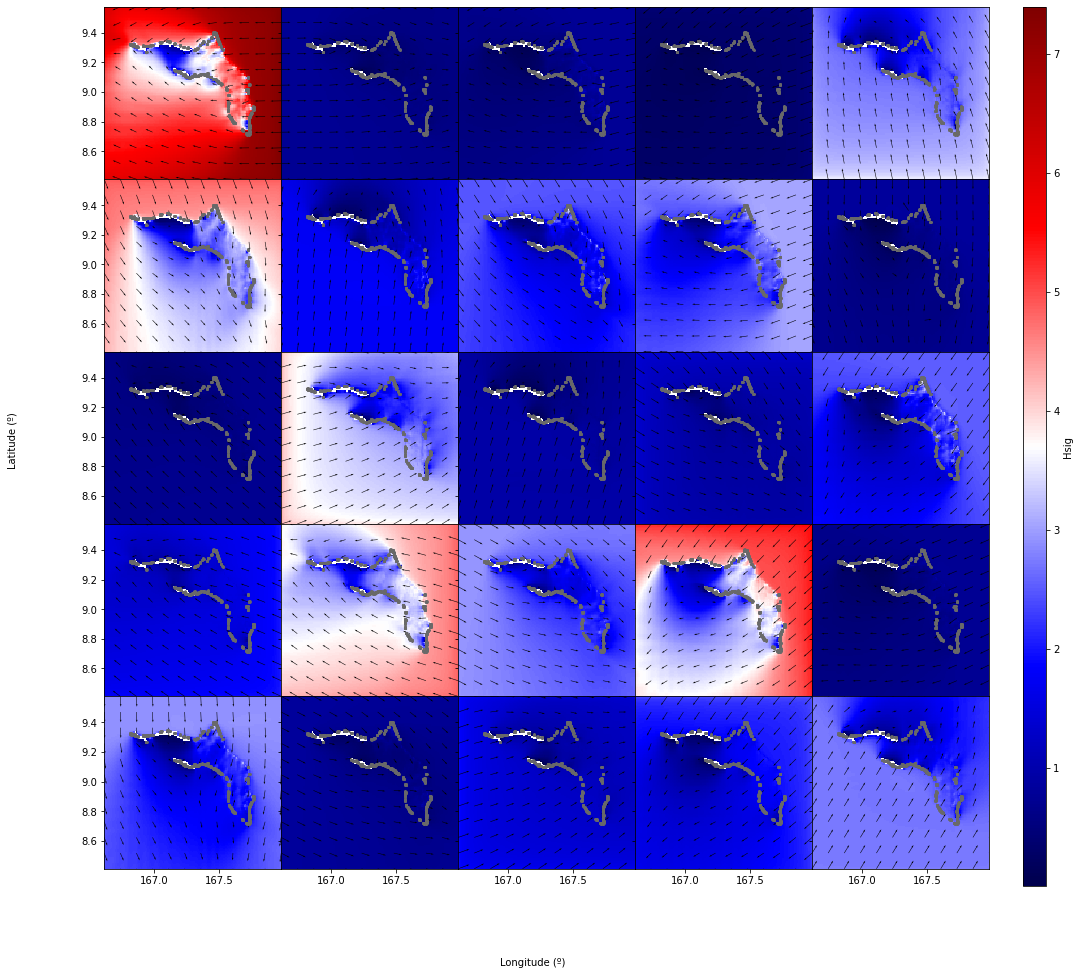

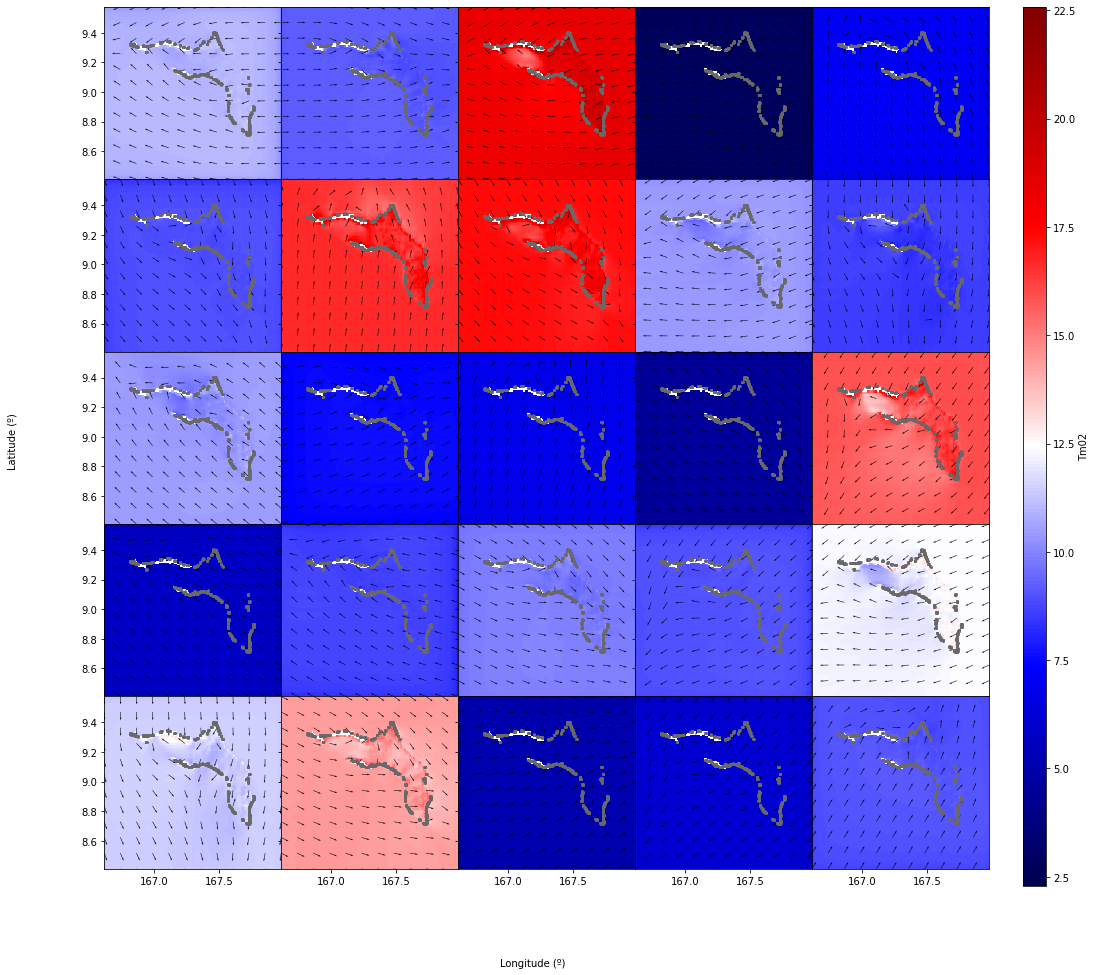

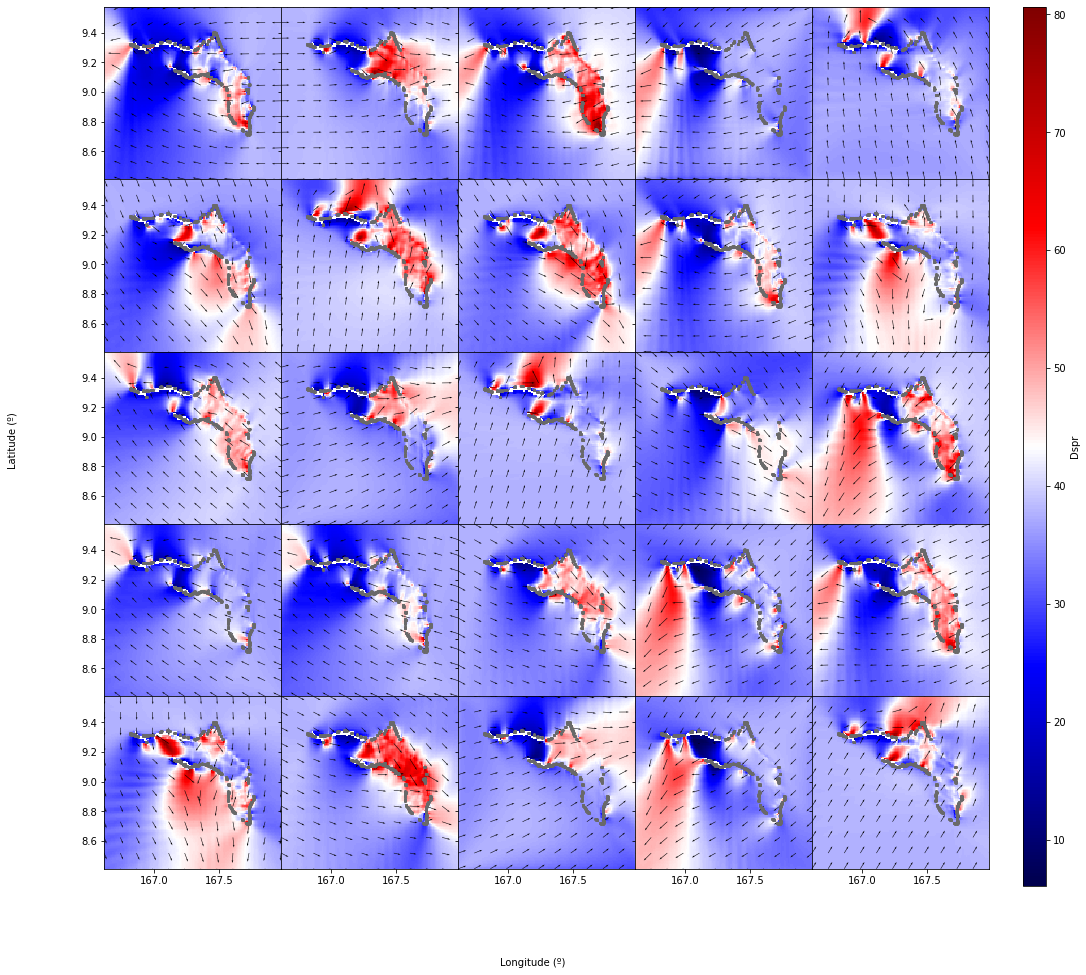

In [11]:
# extract output for main mesh
xds_out = sw.extract_output()
print(xds_out)

# plot scatter maps
scatter_maps(xds_out, n_cases=25, np_shore=np_shore);


<xarray.Dataset>
Dimensions:  (case: 125, lat: 80, lon: 120)
Coordinates:
  * lon      (lon) float64 167.4 167.4 167.4 167.4 ... 167.5 167.5 167.5 167.5
  * lat      (lat) float64 9.351 9.351 9.353 9.354 ... 9.427 9.428 9.429 9.43
Dimensions without coordinates: case
Data variables:
    Hsig     (case, lon, lat) float32 3.1314583 3.2350724 ... 0.44084904
    Tm02     (case, lon, lat) float32 10.831408 10.7807 ... 4.6042714 4.653763
    Dir      (case, lon, lat) float32 54.182266 53.254242 ... 215.13121
    Dspr     (case, lon, lat) float32 38.537163 37.669285 ... 31.983719
    TPsmoo   (case, lon, lat) float32 11.662048 11.649186 ... 4.601645 4.6082745


/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


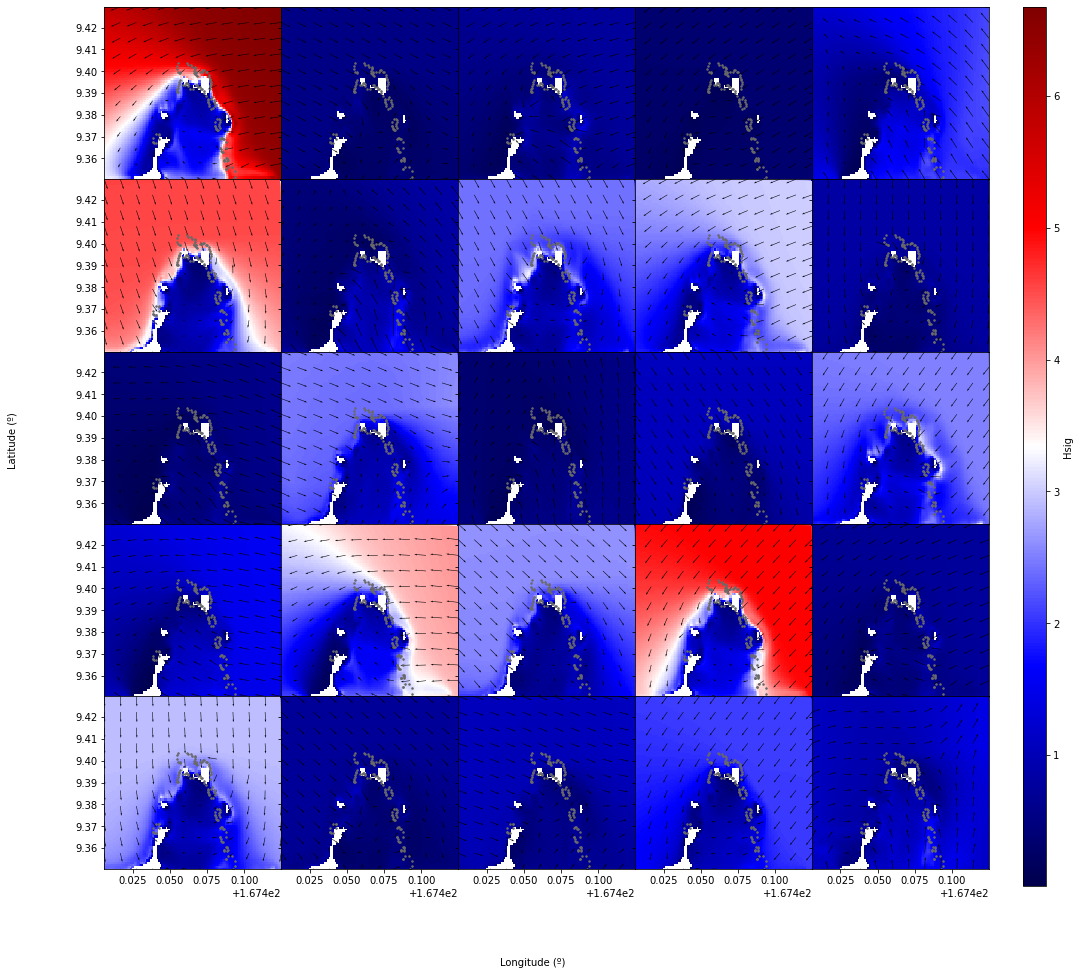

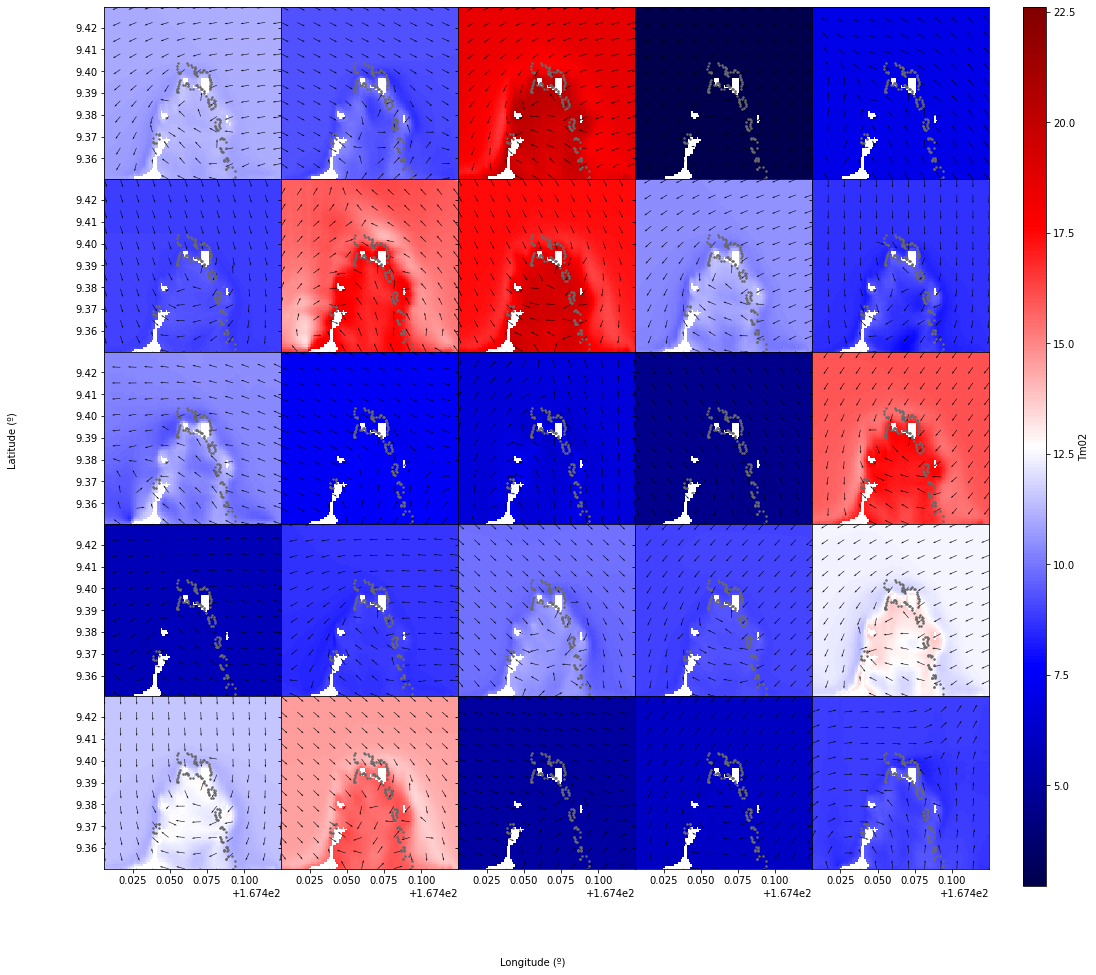

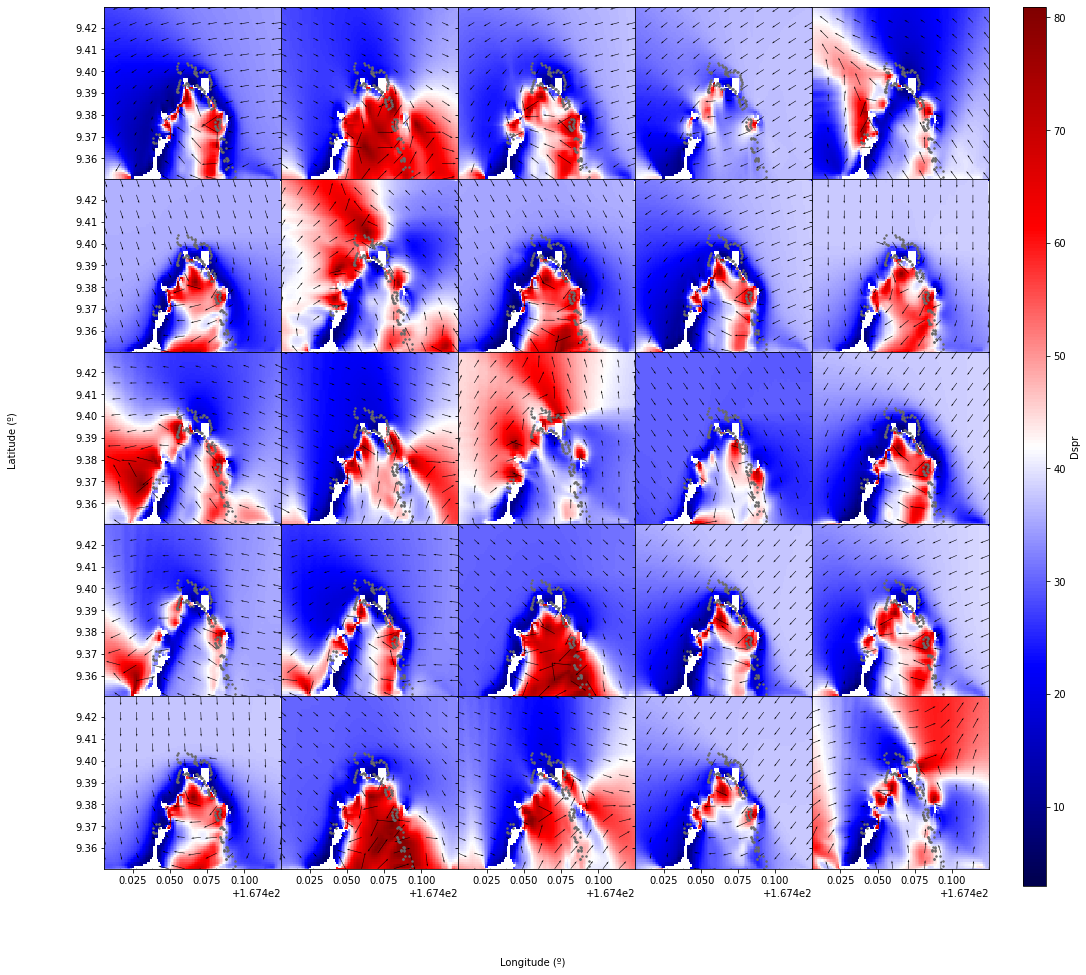

In [13]:
# extract output for nested mesh
xds_out_n1 = sw.extract_output(mesh=sp.mesh_nested_list[0])
print(xds_out_n1)

# plot scatter maps
scatter_maps(xds_out_n1, n_cases=25, np_shore=np_shore);


## SWAN: extract output at a selected point 

In [14]:
# point to reconstruct 
ix_lon, ix_lat = 62, 66

# Extract propagated waves at point (from nest1 mesh)
target = xds_out_n1.isel({'lon':ix_lon, 'lat':ix_lat}).to_dataframe()

# this will be used as RBF target while fitting statistical model
print(target)


           lon     lat      Hsig       Tm02         Dir       Dspr     TPsmoo
case                                                                         
0     167.4679  9.4165  6.362711  11.049024   77.144119  31.550806  11.667482
1     167.4679  9.4165  0.547396   9.276402  298.248535  24.707787  10.640612
2     167.4679  9.4165  0.694775  18.416162   66.468201  31.905077  21.290634
3     167.4679  9.4165  0.346912   2.790912   55.387573  36.231693   2.811212
4     167.4679  9.4165  1.586981   7.030385  117.977463  18.136501   7.238998
...        ...     ...       ...        ...         ...        ...        ...
120   167.4679  9.4165  2.281262   7.887377   73.458710  34.141869   8.644674
121   167.4679  9.4165  0.873592  12.307631  299.677643  24.592058  14.133092
122   167.4679  9.4165  1.247966  10.424542  295.510437  23.191536  11.803345
123   167.4679  9.4165  2.025221   7.739235   94.479187  27.470371   8.187388
124   167.4679  9.4165  0.544625   4.545937  276.214569  32.0491

##  Radial Basis Function reconstruction

In [15]:
# Prepare data

subset.rename(columns={'per':'tp'}, inplace=True)  # reset subset variable name

# select dataset and subset variables
vns_ds = ['hs', 'tp', 'dir']

# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


In [16]:
# Obtain statistical propagation output for the entire waves dataset
output = RBF_Reconstruction(
    subset[vns_ds].values, ix_scalar_subset, ix_directional_subset,
    target[vns_tgt].values, ix_scalar_target, ix_directional_target,
    dataset[vns_ds].values,
)

# mount output as pandas.DataFrame
output = pd.DataFrame(data=output, columns=vns_tgt, index=dataset.index)

print(output)


ix_scalar: 0,  optimization: 2.15 | interpolation: 32.75
ix_scalar: 1,  optimization: 4.78 | interpolation: 32.67
ix_directional: 2,  optimization: 3.80 | interpolation: 62.67
                                   Hsig    TPsmoo        Dir
time                                                        
1979-01-01 00:59:59.999986560  0.346912  2.811212  55.387574
1979-01-01 02:00:00.000013440  0.601640  3.537798  58.521256
1979-01-01 03:00:00.000000000  0.806035  4.146035  62.089600
1979-01-01 03:59:59.999986560  0.961516  4.559256  63.780880
1979-01-01 05:00:00.000013440  1.095864  4.912910  64.313898
...                                 ...       ...        ...
2020-06-30 20:00:00.000013312  0.981626  7.893931  61.413126
2020-06-30 21:00:00.000000000  0.985114  7.893624  60.851256
2020-06-30 21:59:59.999986688  0.986791  7.892428  60.368725
2020-06-30 23:00:00.000013312  0.987503  7.885644  59.951860
2020-07-01 00:00:00.000000000  0.987870  7.876413  59.645425

[363768 rows x 3 columns]
